In [1]:
# get the data ready
import yaml

with open('/Users/sharpr1/data/accessibility/Clustersquestion23.yml') as f:
    cluster_dicts = yaml.safe_load(f)

cluster_dicts

[{'Cluster': 12,
  'text': ['I think we have to move away from the standard poster hall format at large congresses.',
   "Virtual congresses (done well) have shown that the traditional poster format can very easily be expanded on/replaced and we've had some form of ePoster for many years now.",
   'More space for posters.',
   'Wider spaces between posters (so that someone in a wheelchair could move between without taking up all of the space (i.e., not requiring everyone else to move out of the way).',
   'For me, the spaces for poster sessions should not be crowded and the room should be quiet.',
   "Organise poster areas to not have the dreaded ' behind the door' slot that gets no traffic.",
   'The poster session at ISME was terribly claustrophobic',
   'Less crowded posters: space posters out more.',
   'Poster sessions are way too crowded.',
   'I will not attend crowded poster sessions as the crowds/noise increase my anxiety.',
   'More space in poster halls.',
   "make sure post

In [2]:
import csv
datafile = '/Users/sharpr1/github/accessibility/data/write_in_responses.tsv'

lines = []
with open(datafile) as f:
    reader = csv.reader(f, delimiter='\t')
    header = next(reader)
    for line in reader:
        if len(line) != 13:
            print(len(line))
        lines.append(line)

        from collections import defaultdict, namedtuple

import re
pattern = 'Question ([0-9]+) - (.+)'
question_numbers = []
questions = []
question_lut = dict()
for elem in header:
    matched = re.findall(pattern, elem)[0]
    question_number = int(matched[0])
    question = matched[1]
    question_numbers.append(question_number)
    questions.append(question)
    question_lut[question_number] = question
    
print(question_numbers)
print(questions)
        
Response = namedtuple('Response', 'row_id text')

question_answers = defaultdict(list)
# may want to keep the information from the people to correlate with 
# the data in the other questions (e.g., if the person had a visual 
# limitation, are they more likely to request visual accomodation?)
for row_id, line in enumerate(lines):
    for i, resp in enumerate(line):
        if resp:
            question_answers[question_numbers[i]].append(Response(row_id=row_id, text=resp))

question_answers.keys()

[7, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 23]
['If you do have an accessibility need(s) or impairment(s), how do you manage the impact it has on how you receive information in poster or oral presentations? ', 'When attending a poster session, what is your goal in receiving information? Please rate your priority in learning about each of the of the following aspects of the study on a scale of 1 to 5:', 'Traditional layout: Please rate how this poster design impacts your ability to gain information on a scale from 1 to 5. ', '#BetterPoster layout: Please rate how this poster design impacts your ability to gain information on a scale from 1 to 5. ', 'Infographic layout eaxample 1: Please rate how this poster design impacts your ability to gain information on a scale from 1 to 5.', 'Infographic layout eaxample 2: Please rate how this poster design impacts your ability to gain information on a scale from 1 to 5. ', 'What improvements, if any, would you like to see implemented or standa

dict_keys([19, 20, 10, 11, 14, 18, 21, 12, 13, 23, 7, 17, 9])

In [4]:
import nltk

# lookup table from sentence to the speaker id
sent_to_spkr = dict()
for resp in question_answers[23]:
    for sent in nltk.sent_tokenize(resp.text):
        sent_to_spkr[sent] = resp.row_id


In [5]:
cluster_speakers = defaultdict(set)
cluster_sentences = dict()
for cluster_dict in cluster_dicts:
    cluster_id = cluster_dict['Cluster']
    texts = cluster_dict['text']
    cluster_sentences[cluster_id] = len(texts)
    for t in texts:
        cluster_speakers[cluster_id].add(sent_to_spkr[t])

In [28]:
keep = []
for cluster_id in cluster_sentences.keys():
    # At least 3 sentences and at least 3 speakers
    if cluster_sentences[cluster_id] > 2 and len(cluster_speakers[cluster_id]) > 2:
        keep.append(cluster_id)
keep

[12, 50, 26, 23, 30, 46, 43, 22, 49, 15, 51, 3, 39]

In [29]:
from sentence_transformers import SentenceTransformer
import numpy as np

from sklearn import metrics

embedder = SentenceTransformer('all-MiniLM-L6-v2')

def embed_corpus(corp: list[str]):
    embs = embedder.encode(corp)
    # Normalize the embeddings to unit length
    embs = embs /  np.linalg.norm(embs, axis=1, keepdims=True)
    return embs

In [30]:
id_to_cluster = []
id_to_sentence = []
for cluster_dict in cluster_dicts:
    cluster_id = cluster_dict['Cluster']
    if cluster_id in keep:
        for text in cluster_dict['text']:
            id_to_sentence.append(text)
            id_to_cluster.append(cluster_id)

id_to_sentence[:10]

embeds = embed_corpus(id_to_sentence)
embeds

array([[-0.00308866,  0.0394915 ,  0.00235701, ..., -0.02680463,
         0.02248044,  0.00947586],
       [-0.0956049 ,  0.05416444, -0.03525054, ...,  0.01220011,
         0.04418114,  0.03183996],
       [-0.02716308,  0.04578754, -0.03397054, ...,  0.01553158,
        -0.01575852,  0.01695751],
       ...,
       [-0.0036354 ,  0.05553281, -0.04812872, ..., -0.02188176,
         0.05062082,  0.05234819],
       [-0.00743387,  0.03101688, -0.01407413, ..., -0.09320852,
        -0.02071895,  0.07265306],
       [ 0.10238487, -0.00903662,  0.00362351, ..., -0.01262417,
        -0.02636953,  0.0273281 ]], dtype=float32)

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
tsne_model = TSNE(perplexity=50, early_exaggeration=8, n_components=2, n_iter=2500, metric='cosine')
new_embs = tsne_model.fit_transform(np.asarray(embeds))
print(tsne_model.kl_divergence_)

0.19570088386535645


In [33]:
labels = id_to_cluster
sents = id_to_sentence
len(labels) == len(sents) == len(new_embs)

True

In [34]:
def insert_newlines(string, every=64):
    return '\n'.join(string[i:i+every] for i in range(0, len(string), every))

In [35]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

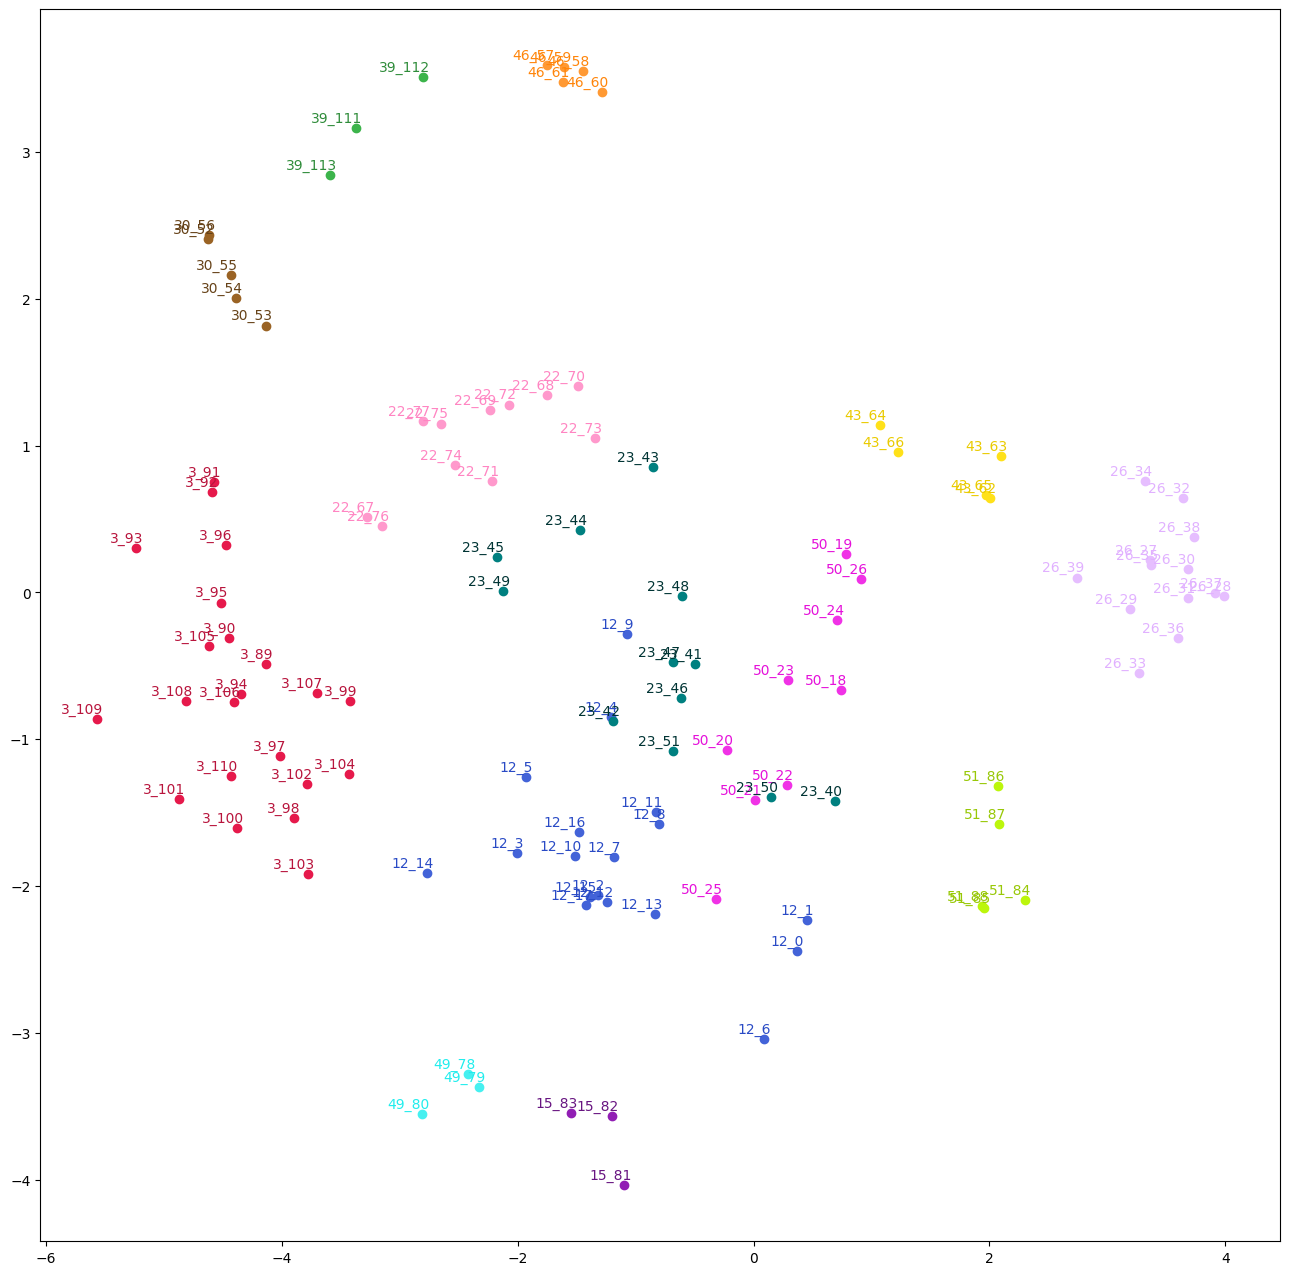

Cluster 12:
	 0 -- I think we have to move away from the standard poster hall format at large congresses.
	 1 -- Virtual congresses (done well) have shown that the traditional poster format can very easily be expanded on/replaced and we've had some form of ePoster for many years now.
	 2 -- More space for posters.
	 3 -- Wider spaces between posters (so that someone in a wheelchair could move between without taking up all of the space (i.e., not requiring everyone else to move out of the way).
	 4 -- For me, the spaces for poster sessions should not be crowded and the room should be quiet.
	 5 -- Organise poster areas to not have the dreaded ' behind the door' slot that gets no traffic.
	 6 -- The poster session at ISME was terribly claustrophobic
	 7 -- Less crowded posters: space posters out more.
	 8 -- Poster sessions are way too crowded.
	 9 -- I will not attend crowded poster sessions as the crowds/noise increase my anxiety.
	 10 -- More space in poster halls.
	 11 -- make sure p

In [37]:
import random

x = []
y = []

cluster_to_color = list(set(id_to_cluster))

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#ff9933', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', 
          '#ff99cc', '#008080', '#e6beff', '#9a6324', '#ff6666', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
          '#000075', '#808080', '#ffffff', '#000000']

for value in new_embs:
    x.append(value[0])
    y.append(value[1])
    
shown = defaultdict(int)

sent_info = defaultdict(list)

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    cluster_label = labels[i]
    cluster_color = colors[cluster_to_color.index(cluster_label)]
    plt.scatter(x[i],y[i], c=cluster_color)
    sent_info[cluster_label].append(f'{i} -- {sents[i]}')
    # ----------
    # Uncomment to show the key to which sentence is which dot
    # ----------
    plt.annotate(insert_newlines(f'{cluster_label}_{i}', 100),
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 color=lighten_color(cluster_color, 1.2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

curr_plt = plt.gcf()
curr_plt.savefig('/Users/sharpr1/data/accessibility/new_plot_with_labels.png')
plt.show()
for k in sent_info:
    print(f'Cluster {k}:')
    for s in sent_info[k]:
        print('\t',s)
    print('')
